This code is for learning MCMC, comparison between data and theory
following the instruction of https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

Starting with Bayesian theorem, given data, the probability of our model (posterior probability) is
\begin{align}
        \begin{split}
            P(model|data) = \frac{P(data|model) P(model)}{P(data)}.
        \end{split}
    \end{align}
    
Or we can rewrite it as
     \begin{align}
        \begin{split}
            P(\theta|D) = \frac{P(D|\theta) P(\theta)}{P(D)}.
        \end{split}
    \end{align}
    
where
- $ P(model|data)$ is "posterior" probability, given data

- $P(data|model)$ is "likelihood", the probability of getting these data, given this model

- $P(model)$ is "prior", the probability of this model

- $P(data)$ is "evidence", the probability of data


Some definitions/concepts:
    
- "MCMCs are a class of methods that most broadly are used to numerically perform multidimensional integrals. However, it is fully true that these methods are highly useful for the practice of inference; that is, fitting models to data." 

- "MCMC allows us to obtain better, more robust uncertainties on your parameters, to understand multi-modalities or covariances in your data, and marginalize out nuisance parameters that you don’t care about, but nevertheless need to include in your modeling to obtain accurate results."

- "The fundamental process of running an MCMC: to compare generated models against data. Those models are generated by a set of parameters, and our goal: to sample from the set of parameters that produces the models that well-fit our data."

- MCMC allow us to estimate the posterior distribution (LHS) by numerically integrating the RHS, for some given expectation value

\begin{align}
    E(\theta) = \int \theta p(\theta) d\theta \approx \frac{1}{N} \sum_i^N \theta_i,
\end{align}

or for any function of $\theta$

\begin{align}
    E(g(\theta)) = \int g(\theta) p(\theta) d\theta,
\end{align}

In [136]:
import numpy as np
import matplotlib.pyplot as plt

In [137]:
import emcee

In [138]:
import corner

In [139]:
import astropy.io.fits as fits

In [140]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [141]:
N_GC = data['NGCs']
Mag_z = data['Mag z']

In [142]:
err_GC = data['err GC']

<ErrorbarContainer object of 3 artists>

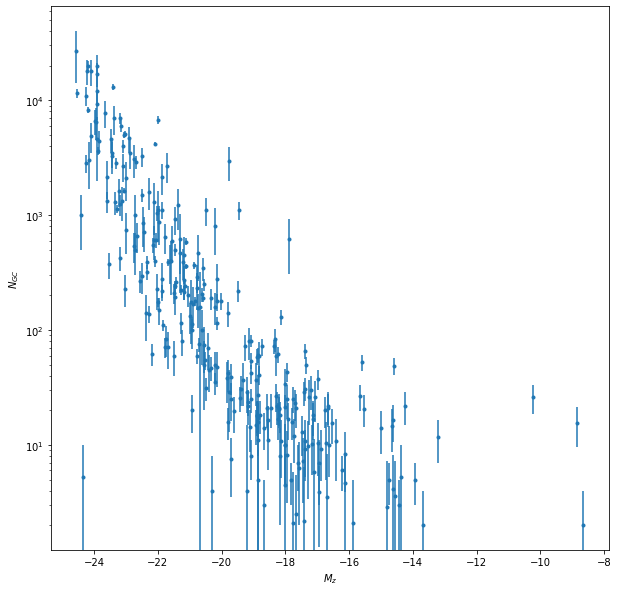

In [143]:
plt.figure(figsize=(10,10))
plt.xlabel('$M_z$')
plt.ylabel('$N_{GC}$')
plt.yscale('log')
plt.errorbar(Mag_z,N_GC,yerr=err_GC,fmt='.')

The fitting model could be

$ y(x) = N\left[a\left(\frac{x}{M_1}\right)^\alpha + b\left(\frac{x}{M_1}\right)^\beta \right]$

where x, y are magnitude and number of GCs, respectively; N, a, b, $\alpha, \beta, M_1$ are parameters.

In [144]:
def model(para, mag=Mag_z): #para = all parameters in the model, mag = x axis
    a, alpha, b, beta, M1, N = para 
    model = N*(a*(mag/M1)**alpha + b*(mag/M1)**beta)
    return model

 a, b = para define a function that return how good a fit our model is to the data, for the given set of parameters, weighted by the error in the data points (simple $\chi^2$ type check). 

\begin{align}
    L_{lnlike} = -0.5\sum \left(\frac{y-y_{model}}{y_{err}}\right)^2
\end{align}

- If the new model returns better fit compare to the default model (by an acceptance ratio), the walker will move toward that and repeat the process.

- Every walker keeps a record of $\theta$ and the likelihood of the model given data at value $\theta$.

- As if MCMC runs long enough to converge, it represents a sample of reasonable models to describe the data;



In [145]:
def lnlike(para, mag, y, yerr):
    lnlike = -0.5*np.sum(((y-model(para,mag))/yerr)**2)
    return lnlike

In [146]:
# the things we know (fact/conditions to the parameters)
def lnprior(para):
    a, alpha, b, beta, M1, N = para 
    if 10 < a < 25 and 20<alpha<45 and -10 < b < 10  and -1<beta<1  and -26<M1<-14 and -1<N<3: 
         return 0.0
    else:
        return -np.inf

In [147]:
# the function as lnprior output + lnlike output
def lnprob(para, mag, y, yerr):
    lp = lnprior(para)
    if not np.isfinite(lp): #check if input prior satisfy the parameter space
        return -np.inf
    return lp + lnlike(para, mag, y, yerr)

In [148]:
data     = (Mag_z, N_GC, err_GC)
nwalkers = 150
niter    = 10000
initial  = np.array([20, 30, 4, 0.2, -20, 2]) # initial set of values of the parameters (guess) [a, alpha, b, beta, norm, M1]
ndim     = len(initial)

# A list of the initial positions of the walkers in the parameter space. It should have the shape ``(nwalkers, dim)
#stepping from one place to the next, generate N-dimensional parameters space close to the current location
p0       = [np.array(initial) + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]

In [149]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim,lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [150]:
#run emcee to get posterior (pos), probability, state(?)
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


ValueError: Probability function returned NaN

        At each iteration, this generator yields:

        * ``pos`` - A list of the current positions of the walkers in the
          parameter space. The shape of this object will be
          ``(nwalkers, dim)``.

        * ``lnprob`` - The list of log posterior probabilities for the
          walkers at positions given by ``pos`` . The shape of this object
          is ``(nwalkers, dim)``.


In [ ]:
print(prob)

In [ ]:
def plotter(sampler,mag=Mag_z, N=N_GC):
    plt.ion()
    plt.figure(figsize=(10,10))
    plt.yscale("log")
    plt.errorbar(Mag_z,N, yerr = err_GC,fmt='.',label='data')
    samples = sampler.flatchain
    for para in samples[np.random.randint(len(samples), size=10)]:
        plt.plot(Mag_z, model(para, Mag_z),'.', color='grey', alpha=0.3)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('$M_z$')
    plt.ylabel('$N_{GC}$')
    plt.legend()
    plt.show()

In [ ]:
plotter(sampler)

In [ ]:
fig, axes = plt.subplots(6, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ['a','alpha' ,'b','beta', 'M1', 'N']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i],alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

In [ ]:
plt.plot(sampler.acceptance_fraction, '-')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [ ]:
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))

In [ ]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
#value of each parameter, highest likelihood model 

In [ ]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max,Mag_z)
plt.figure(figsize=(10,10))
plt.errorbar(Mag_z,N_GC,yerr=err_GC,fmt='.')
plt.plot(Mag_z,best_fit_model,'.',label='Highest Likelihood Model')
plt.yscale("log")
#plt.ylim(0,100)
plt.show()
print ('para max: ',theta_max)

In [ ]:
#posterior spread
#labels = ['a','alpha' ,'b','beta', 'M1']
fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
#fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels, plot_datapoints= False,smooth=True,quantiles=[0.16, 0.5, 0.84])